Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests

1. Get the time series data for different cryptos and get it in required format

In [2]:
###Function to request the data for a given cryptocurrency(token)
def get_data(token):
    #Loop over the following exchanges to get the required data
    exchanges = ['coinbase-pro','kraken']
    df = pd.DataFrame()
    for exchange in exchanges:
        res = requests.get(
            f'https://api.cryptowat.ch/markets/{exchange}/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )
        # break from the loop if the current exchange has the data for the token
        if res.status_code == 200:
            df = pd.DataFrame(
                res.json()['result']['3600'],
                columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
            )
            df['ts'] = pd.to_datetime(df.ts, unit='s')
            df['token'] = token
            df['exchange'] = exchange
            break
    
    return df

In [3]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT','FLOW']
df = pd.concat([get_data(token) for token in tokens]).set_index('ts')
display(df.head())

,open,high,low,close,volume,volumeUSD,token,exchange
ts,,,,,,,,
2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,coinbase-pro
2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,coinbase-pro
2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,coinbase-pro
2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,coinbase-pro
2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,coinbase-pro


2. Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume

In [4]:
volume_df = df.groupby('token').volumeUSD.sum().sort_values(ascending = False).to_frame()
display(volume_df)

,volumeUSD
token,
ETH,2.263734e+10
SOL,7.393826e+09
AVAX,3.748893e+09
USDT,2.066447e+09
FLOW,9.046054e+07


3. Add a column that calculates the close price ratio between ETH and SOL for each hour

In [5]:
close_df = pd.concat([df[df.token == token].close.to_frame().rename(columns = {'close':token}) for token in tokens],axis=1)

ratio_close = (close_df['ETH']/close_df['SOL']).to_frame().rename(columns = {0:'ETH_SOL_ratio'})

df = pd.merge(df,ratio_close,on='ts',how='left')
display(df.head())

,open,high,low,close,volume,volumeUSD,token,exchange,ETH_SOL_ratio
ts,,,,,,,,,
2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,coinbase-pro,18.471694
2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,coinbase-pro,18.736150
2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,coinbase-pro,18.577985
2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,coinbase-pro,18.794937
2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,coinbase-pro,18.891059


4. Change the name of the volume and volumeUSD columns to volumeBase and volumeTerm

In [6]:
df.rename(columns = {'volume': 'volumeBase','volumeUSD': 'volumeTerm'}, inplace=True)
display(df.head())

,open,high,low,close,volumeBase,volumeTerm,token,exchange,ETH_SOL_ratio
ts,,,,,,,,,
2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,coinbase-pro,18.471694
2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,coinbase-pro,18.736150
2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,coinbase-pro,18.577985
2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,coinbase-pro,18.794937
2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,coinbase-pro,18.891059


5 .Create a fat table indexed by the timestamp, and each column is the close price of each token

In [7]:
close_df = pd.concat([df[df.token == token].close.to_frame().rename(columns = {'close':token}) for token in tokens],axis=1)
display(close_df.head())

,ETH,SOL,AVAX,USDT,FLOW
ts,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581


6 . Calculate the hour by hour log return of the close price of each token

In [8]:
return_df = np.log(close_df/close_df.shift(1))
display(return_df.head())

,ETH,SOL,AVAX,USDT,FLOW
ts,,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,-0.006736,-0.020952,0.046912,0.0001,-0.038102
2021-11-22 02:00:00,-0.003900,0.004578,-0.017279,-0.0001,0.009644
2021-11-22 03:00:00,-0.005806,-0.017417,0.006318,-0.0001,-0.007371
2021-11-22 04:00:00,-0.006008,-0.011109,0.021583,-0.0002,-0.005214


7. Calculate the correlation of the tokens using the table above

In [9]:
corr_df = return_df.corr()
display(corr_df)

,ETH,SOL,AVAX,USDT,FLOW
ETH,1.000000,0.749861,0.647072,-0.110605,0.575318
SOL,0.749861,1.000000,0.629386,0.099126,0.467118
AVAX,0.647072,0.629386,1.000000,-0.012098,0.396981
USDT,-0.110605,0.099126,-0.012098,1.000000,-0.189231
FLOW,0.575318,0.467118,0.396981,-0.189231,1.000000


8. visualize the correlation in a matplpotlib plot

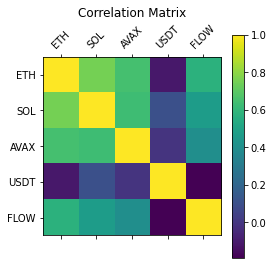

In [10]:
import matplotlib.pyplot as plt

plt.matshow(corr_df)
plt.xticks(np.arange(len(corr_df)),corr_df.index, rotation=45)
plt.yticks(np.arange(len(corr_df)),corr_df.index)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix')
plt.show()